# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

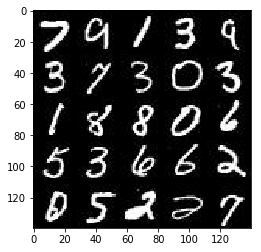

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

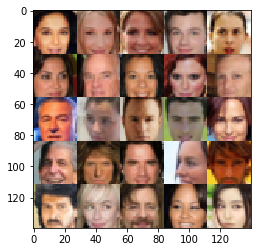

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # dims = batch, width, height, features
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def LRelu(x,alpha=0.05,name='LRelu'):
    #there's only so many times I can write the line tf.maximum(alpha * x, x)
    return tf.maximum(alpha * x, x,name=name)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Leaky ReLU
    #    h1 = tf.maximum(alpha * h1, h1)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        #conv stack
        
        #first layer is 28x28x3
        c1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        c1 = LRelu(c1)
        
        #second
        c2 = tf.layers.conv2d(c1, 128, 5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = LRelu(c2)
        
        #third
        c3 = tf.layers.conv2d(c2, 256, 5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = LRelu(c3)
        
        #Flatten
        flat = tf.reshape(c3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


# There's too many magic numbers floating around here, but at this point I'm gonna focus on the network itself.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        
        #first
        d1 = tf.layers.dense(z, 4*4*256) #magic numbeeers
        d1 = tf.reshape(d1, (-1, 4, 4, 256))
        d1 = tf.layers.batch_normalization(d1, training=is_train)
        d1 = LRelu(d1)
        
        
        #second
        c2 = tf.layers.conv2d_transpose(d1, 128, 4, strides=1, padding='valid') 
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = LRelu(c2)
        
        #third
        c3 = tf.layers.conv2d_transpose(c2, 64, 4, strides=2, padding='same') 
        c3 = tf.layers.batch_normalization(c3, training=is_train)
        c3 = LRelu(c3)
        
        
        logits = tf.layers.conv2d_transpose(c3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
        
    # label smoothing as shown in videos
    smooth = 0.1
    
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_real, dis_logits_real = discriminator(input_real, reuse=False)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_logits_real, labels=tf.ones_like(dis_model_real)*(1-smooth)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    
    dis_loss = dis_loss_real + dis_loss_fake
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #get vars with https://www.tensorflow.org/api_docs/python/tf/trainable_variables
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]    
    
    # Hardest part from the last two functions was finding the correct API calls, not the model itself.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Based on previous train loops... but seriously, the new estimator() API is a godsend.
    # On the other hand, this forced me to understand train() loops more in depth
    print_every=10 
    show_every=100
    
    _, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                #from forum ttps://discussions.udacity.com/t/generator-loss-greater-than-discriminator-loss/247897/3
                #jesus training() loops from TF are just ...I mean, for this course are good to understand the whole process,
                #but for normal use you will take Keras from my cold, dead hands
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                #sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                     show_generator_output(sess, 25, input_z, channels, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6203... Generator Loss: 13.3990
Epoch 1/2... Discriminator Loss: 2.0633... Generator Loss: 0.2128
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 2.7447
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 2.2591
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.3302
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 2.8163
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 3.1375
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 2.0812


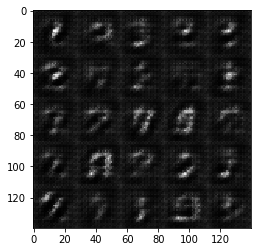

Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.4355
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 2.0739
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.5774


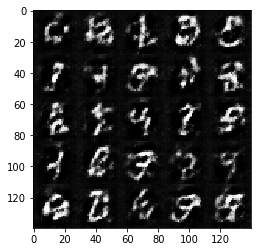

Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 1.8118
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 1.9490
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.4256
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.0847


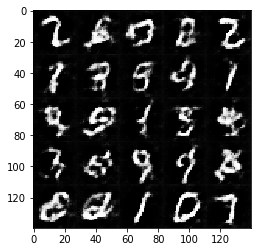

Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.6034
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 1.7061
Epoch 1/2... Discriminator Loss: 1.7013... Generator Loss: 0.3317
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.8743... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 1.6761
Epoch 1/2... Discriminator Loss: 0.9842... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 1.7256
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.9444


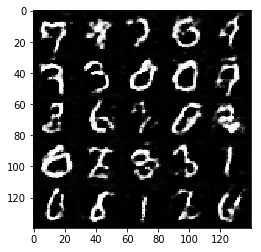

Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 2.5766... Generator Loss: 3.7689
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.9673
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 2.0780
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 1.0926


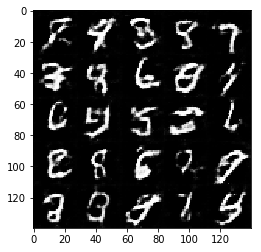

Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 0.4135
Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.3761
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 2.0659
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 2.2246


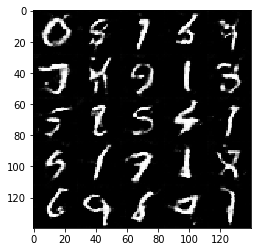

Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.8817
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.1380


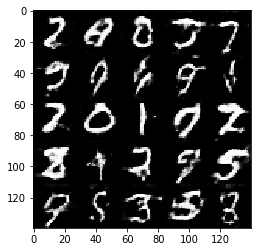

Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.5147
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.3349
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.7947
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.3893


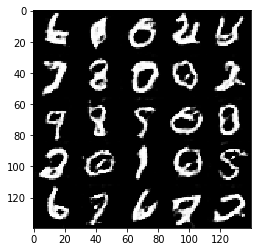

Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 1.6126
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 1.9223
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 1.6980
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 1.4238
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 1.8935
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.5648


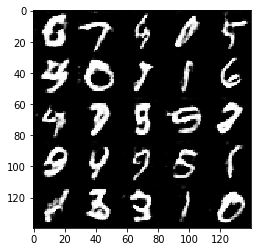

Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.4013
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 1.5038
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.9727
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 1.8992... Generator Loss: 3.2668
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 1.6507... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.3282
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.0568... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.9906


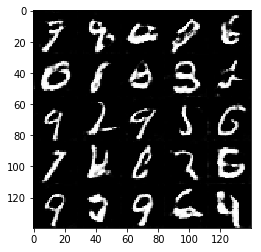

Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 1.7364... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 2.4315
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 2.6174
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.3423
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.1013


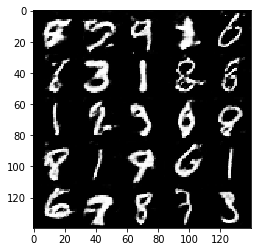

Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.7056
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.2763
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 1.4815
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 2.1912
Epoch 2/2... Discriminator Loss: 1.6038... Generator Loss: 0.4141
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.8020
Epoch 2/2... Discriminator Loss: 1.7541... Generator Loss: 3.0303
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.6286


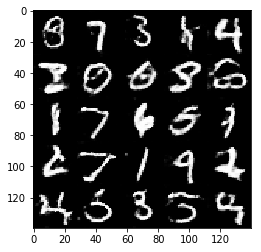

Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.4237
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5250
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 1.5361... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.5933


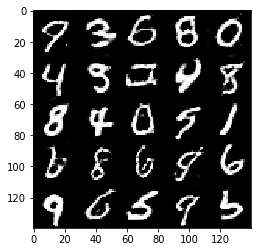

Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.1154... Generator Loss: 2.1436
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.5434
Epoch 2/2... Discriminator Loss: 4.9978... Generator Loss: 5.9802
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.8836


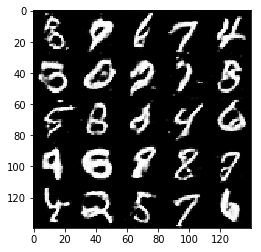

Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.5189... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 2.2368... Generator Loss: 0.2488
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.4841
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.7700... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 1.6845... Generator Loss: 0.4341


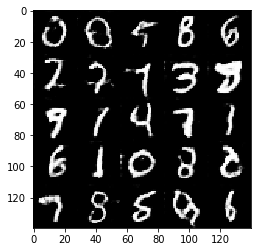

Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.9484
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 2.1933
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 1.2640
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.9011
Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.5932
Epoch 2/2... Discriminator Loss: 1.9429... Generator Loss: 4.1728
Epoch 2/2... Discriminator Loss: 1.0897... Generator Loss: 2.1034


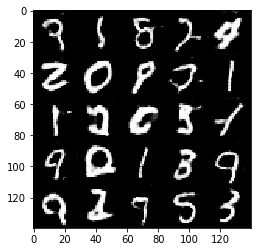

Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 2.3251
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.7222
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.6644
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.8378


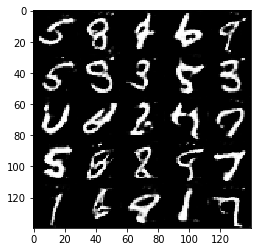

Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.5953
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.6468
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 2.8244
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.2065
Epoch 2/2... Discriminator Loss: 1.8062... Generator Loss: 4.2576


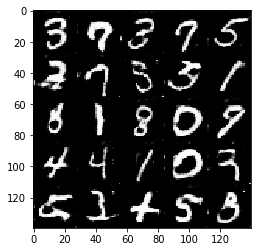

Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.7263
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.2387


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 8.7150
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 5.4720
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 2.9401
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9600


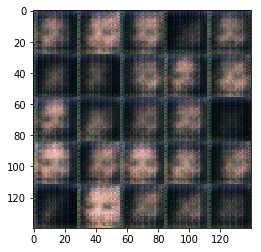

Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 2.1550
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 1.8968... Generator Loss: 3.1962
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 2.3186... Generator Loss: 0.2080
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 1.7622
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 2.1203
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.4592


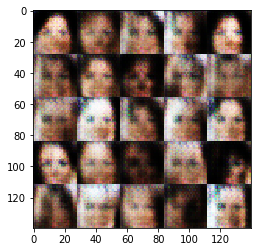

Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 2.1716
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.8438... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.6293


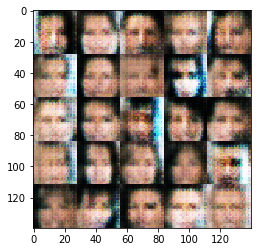

Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 2.2501
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.6669
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2622


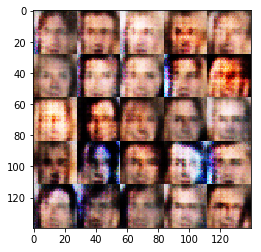

Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 2.3106
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.3075
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 1.7759
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8854


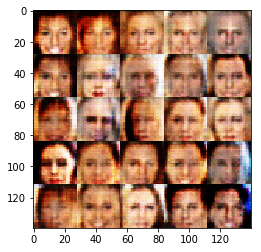

Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.6996
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.9456


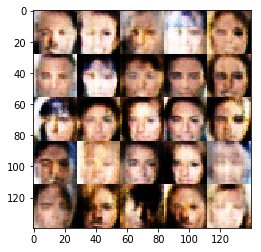

Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.5976
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.4440


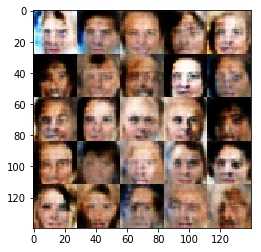

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.3910
Epoch 1/1... Discriminator Loss: 2.3382... Generator Loss: 3.6030
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 2.8237... Generator Loss: 3.2791
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9196


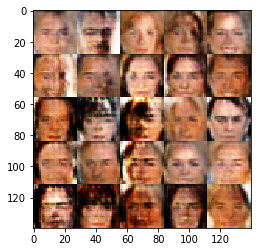

Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9920


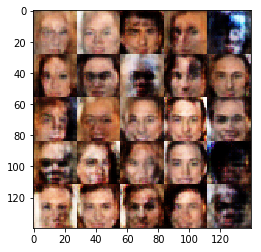

Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.8029
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8138


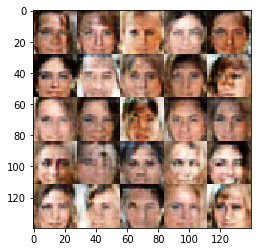

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.6565
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.2887
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.3475


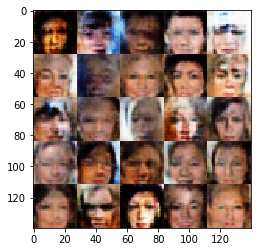

Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 1.9718


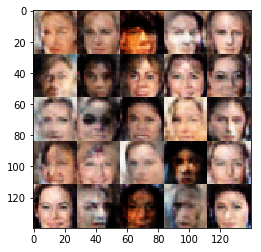

Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.8277


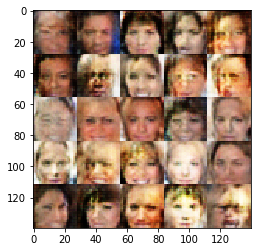

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.2643


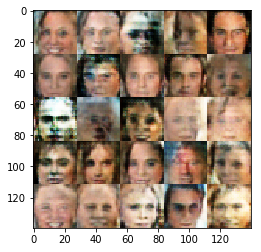

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.8202


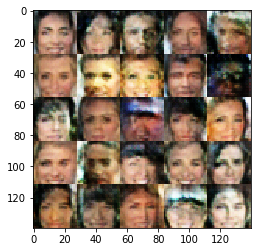

Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.6096
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6860


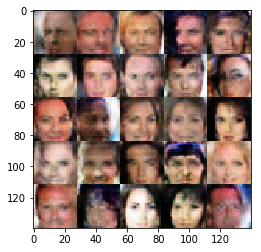

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.9133... Generator Loss: 0.2727
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6122


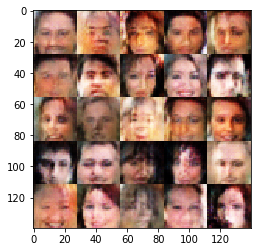

Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.9507


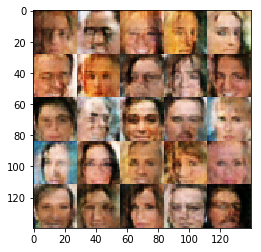

Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 1.7909
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4644


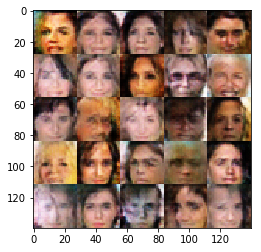

Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.2174


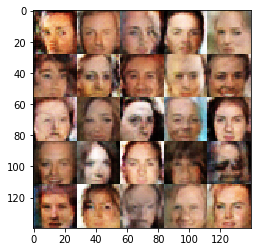

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.1832


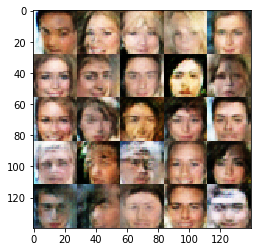

Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.4635


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.